In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session


In [2]:
df=pd.read_csv('creditcard.csv')
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [6]:
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.express as px
from matplotlib import pyplot as plt
from sklearn.model_selection import cross_val_score

from sklearn import metrics
from collections import Counter

In [7]:
raw_df = pd.read_csv('creditcard.csv')

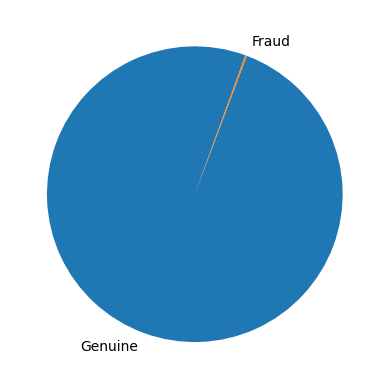

In [8]:
labels=["Genuine","Fraud"]

fraud_or_not = raw_df["Class"].value_counts().tolist()
values = [fraud_or_not[0], fraud_or_not[1]]
plt.pie(values, labels = labels,startangle=70)
plt.show() 

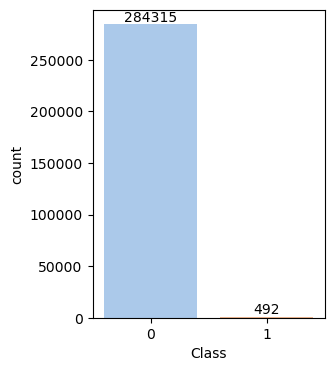

In [9]:
plt.figure(figsize=(3,4))
ax = sns.countplot(x='Class',data=raw_df,palette="pastel")
for i in ax.containers:
    ax.bar_label(i,)

In [10]:
print('Genuine:', round(raw_df['Class'].value_counts()[0]/len(raw_df) * 100,2), '% of the dataset')
print('Frauds:', round(raw_df['Class'].value_counts()[1]/len(raw_df) * 100,2), '% of the dataset')

Genuine: 99.83 % of the dataset
Frauds: 0.17 % of the dataset


In [11]:
df = raw_df.copy()

df.drop_duplicates(inplace=True)
print("Duplicated values dropped succesfully")
print("*" * 100)

Duplicated values dropped succesfully
****************************************************************************************************


In [12]:
df = df.drop('Time', axis=1)

In [13]:
numeric_columns = (list(df.loc[:, 'V1':'Amount']))

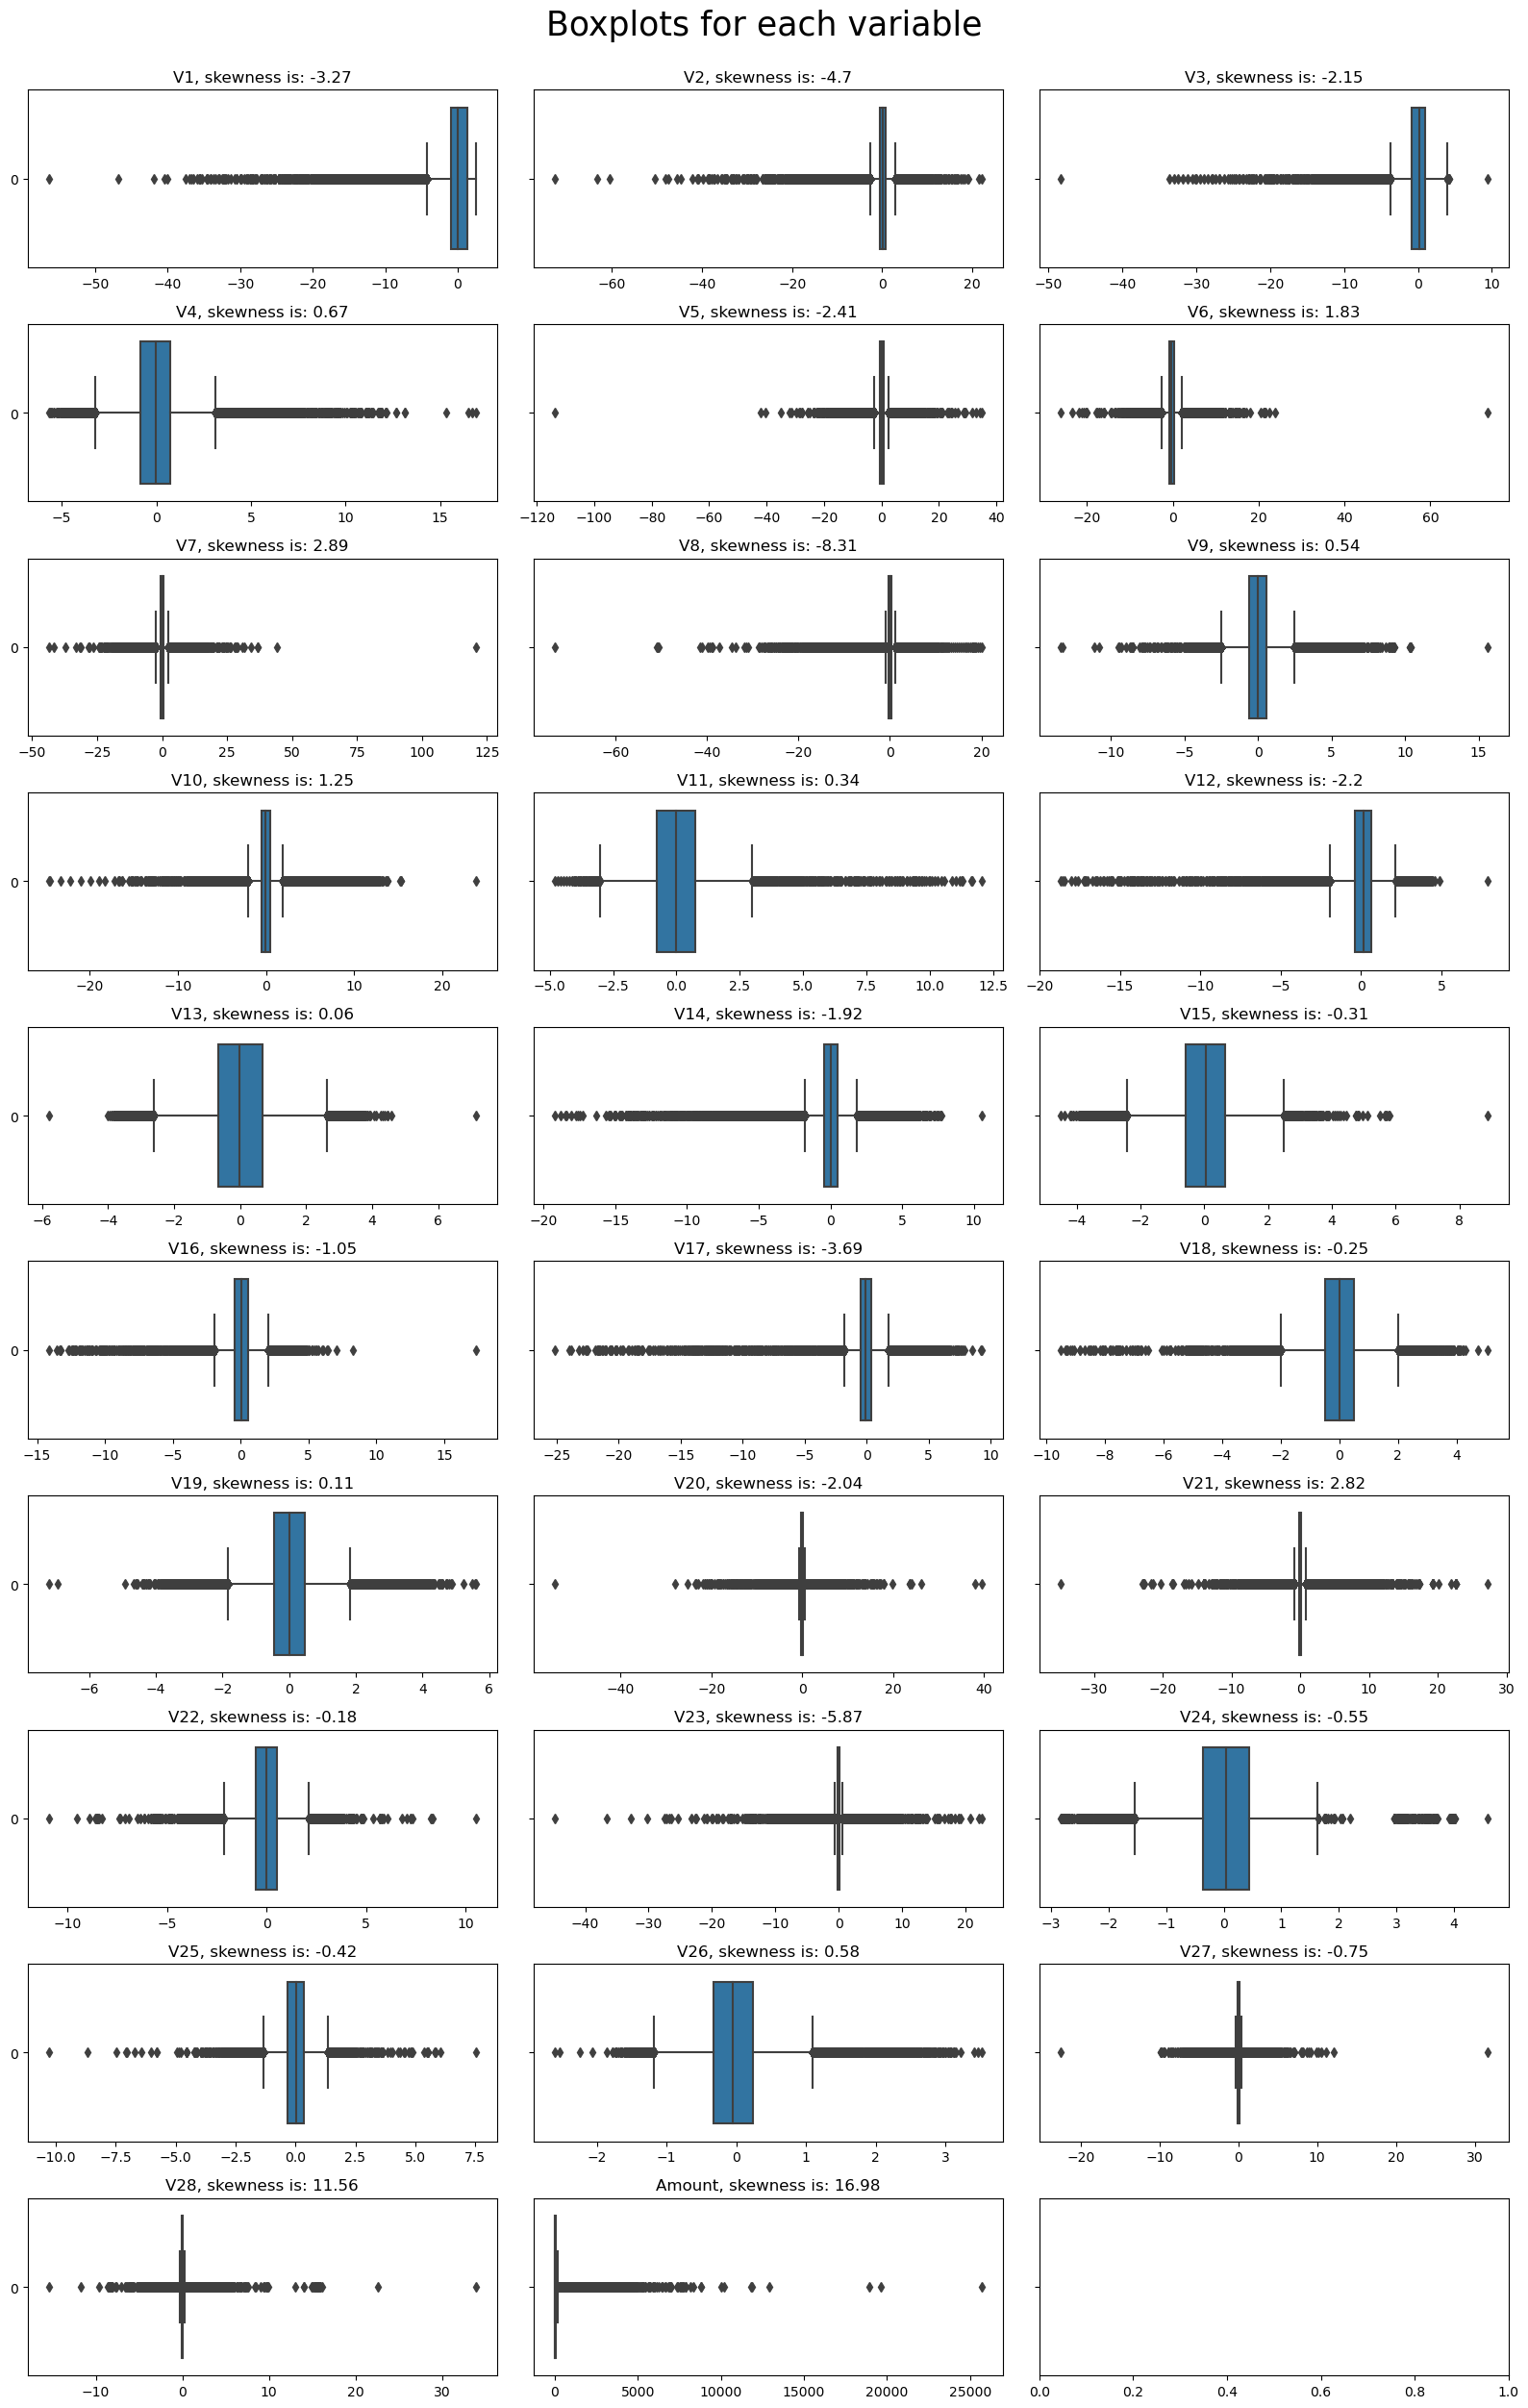

In [14]:
def boxplots_custom(dataset, columns_list, rows, cols, suptitle):
    fig, axs = plt.subplots(rows, cols, sharey=True, figsize=(16,25))
    fig.suptitle(suptitle,y=1, size=25)
    axs = axs.flatten()
    for i, data in enumerate(columns_list):
        sns.boxplot(data=dataset[data], orient='h', ax=axs[i])
        axs[i].set_title(data + ', skewness is: '+str(round(dataset[data].skew(axis = 0, skipna = True),2)))
        
boxplots_custom(dataset=df, columns_list=numeric_columns, rows=10, cols=3, suptitle='Boxplots for each variable')
plt.tight_layout()

In [16]:
def IQR_method (df,n,features):
    outlier_list = []
    
    for column in features:
        # 1st quartile (25%)
        Q1 = np.percentile(df[column], 25)
        # 3rd quartile (75%)
        Q3 = np.percentile(df[column],75)
        # Interquartile range (IQR)
        IQR = Q3 - Q1
        # outlier step
        outlier_step = 1.5 * IQR
        # Determining a list of indices of outliers
        outlier_list_column = df[(df[column] < Q1 - outlier_step) | (df[column] > Q3 + outlier_step )].index
        # appending the list of outliers 
        outlier_list.extend(outlier_list_column)
        
    # selecting observations containing more than x outliers
    outlier_list = Counter(outlier_list)        
    multiple_outliers = list( k for k, v in outlier_list.items() if v > n )
    
    # Calculate the number of records below and above lower and above bound value respectively
    out1 = df[df[column] < Q1 - outlier_step]
    out2 = df[df[column] > Q3 + outlier_step]
    
    print('Total number of deleted outliers is:', out1.shape[0]+out2.shape[0])
    
    return multiple_outliers

In [17]:
# detecting outliers
Outliers_IQR = IQR_method(df,1,numeric_columns)

# dropping outliers
df_out = df.drop(Outliers_IQR, axis = 0).reset_index(drop=True)

Total number of deleted outliers is: 31685


In [18]:
X = df.drop('Class', axis=1)
y = df['Class']

In [19]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size = 0.3, random_state = 42)

In [20]:
from sklearn.preprocessing import StandardScaler

# Creating function for scaling
def Standard_Scaler (df, col_names):
    features = df[col_names]
    scaler = StandardScaler().fit(features.values)
    features = scaler.transform(features.values)
    df[col_names] = features
    
    return df

In [21]:
col_names = ['Amount']
X_train = Standard_Scaler (X_train, col_names)
X_test = Standard_Scaler (X_test, col_names)

In [22]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators = 100)

# Training the model on the training dataset
# fit function is used to train the model using the training sets as parameters
clf.fit(X_train, y_train)

# performing predictions on the test dataset
y_pred = clf.predict(X_test)

# metrics are used to find accuracy or error
from sklearn import metrics
print()

# using metrics module for accuracy calculation
print("ACCURACY OF THE MODEL: ", metrics.accuracy_score(y_test, y_pred))


ACCURACY OF THE MODEL:  0.9995418125425879


In [23]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf # tensorflow, a deep learning framework
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [24]:
tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


False

In [25]:
X = raw_df.drop('Class', axis=1)
y = raw_df['Class']

In [26]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size = 0.3, random_state = 42)

In [27]:
model = tf.keras.models.Sequential([
    
  tf.keras.layers.Dense(15, activation='tanh'),
  tf.keras.layers.Dropout(0.5),
  tf.keras.layers.Dense(15, activation='tanh'),
  tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(10, activation='gelu'),
    tf.keras.layers.Dense(10, activation='selu'),
    tf.keras.layers.Dense(3, activation='gelu'),
    tf.keras.layers.Dense(3, activation='selu'),
    
  tf.keras.layers.Dense(1, activation='sigmoid')
])

In [28]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy','AUC'])


In [29]:
model.fit(X_train,y_train,validation_split = 0.20, batch_size = 1024, epochs = 10)

Epoch 1/10
156/156 [==============================] - 7s 14ms/step - loss: 0.1613 - accuracy: 0.9591 - auc: 0.5149 - val_loss: 0.0139 - val_accuracy: 0.9981 - val_auc: 0.4995
Epoch 2/10
156/156 [==============================] - 1s 6ms/step - loss: 0.0184 - accuracy: 0.9983 - auc: 0.4935 - val_loss: 0.0151 - val_accuracy: 0.9981 - val_auc: 0.5000
Epoch 3/10
156/156 [==============================] - 1s 4ms/step - loss: 0.0164 - accuracy: 0.9983 - auc: 0.5069 - val_loss: 0.0156 - val_accuracy: 0.9981 - val_auc: 0.5000
Epoch 4/10
156/156 [==============================] - 1s 4ms/step - loss: 0.0159 - accuracy: 0.9983 - auc: 0.4937 - val_loss: 0.0154 - val_accuracy: 0.9981 - val_auc: 0.5000
Epoch 5/10
156/156 [==============================] - 1s 4ms/step - loss: 0.0149 - accuracy: 0.9983 - auc: 0.5110 - val_loss: 0.0153 - val_accuracy: 0.9981 - val_auc: 0.5000
Epoch 6/10
156/156 [==============================] - 1s 4ms/step - loss: 0.0149 - accuracy: 0.9983 - auc: 0.5017 - val_loss: 0.0

In [30]:
yhat = model.predict(X_test)
np.unique(yhat)

2671/2671 [==============================] - 4s 2ms/step


array([0.00112898, 0.00112918, 0.00112954, 0.0011349 , 0.00113515,
       0.00113579, 0.00113633, 0.00113677, 0.00113682, 0.00113697,
       0.00113715, 0.00113719, 0.00113721, 0.00113726, 0.0011373 ,
       0.00113731, 0.00113733, 0.00113734, 0.00113738, 0.00113743,
       0.0011375 , 0.00113753, 0.00113753, 0.00113754, 0.00113755,
       0.00113756, 0.00113757, 0.00113757, 0.00113757, 0.00113757,
       0.00113757, 0.00113758, 0.00113759, 0.00113759, 0.00113759,
       0.0011376 , 0.0011376 , 0.00113761, 0.00113761, 0.00113761,
       0.00113761, 0.00113761, 0.00113761, 0.00113761, 0.00113761,
       0.00113761, 0.00113762, 0.00113762, 0.00113762, 0.00113762,
       0.00113763, 0.00113763, 0.00113764, 0.00113764, 0.00113765,
       0.00113771, 0.00113771, 0.00113777, 0.00113781, 0.0011379 ,
       0.00113798, 0.00113806, 0.00113807, 0.00113826, 0.00113838,
       0.00113879, 0.00113884, 0.00113895, 0.00113899, 0.00113924,
       0.00114007, 0.00114311, 0.00114677, 0.00114829, 0.00114

In [31]:
ypre=[]
for i in range(len(yhat)):
    if(yhat[i]>-0.5):
        ypre.append(0)
    else:
        ypre.append(1)

In [32]:
print("ACCURACY OF THE MODEL: ", metrics.accuracy_score(y_test, ypre))

ACCURACY OF THE MODEL:  0.9982678510820079
